# 1. Implementation of the Dataset and Preparation

In [4]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
import plotly.express as px
import pickle
import matplotlib.pyplot as plt
import os

# read dataset
df = pd.read_csv("../ALLFLOWMETER_HIKARI2021.csv")

## Label Distribution of the Dataset

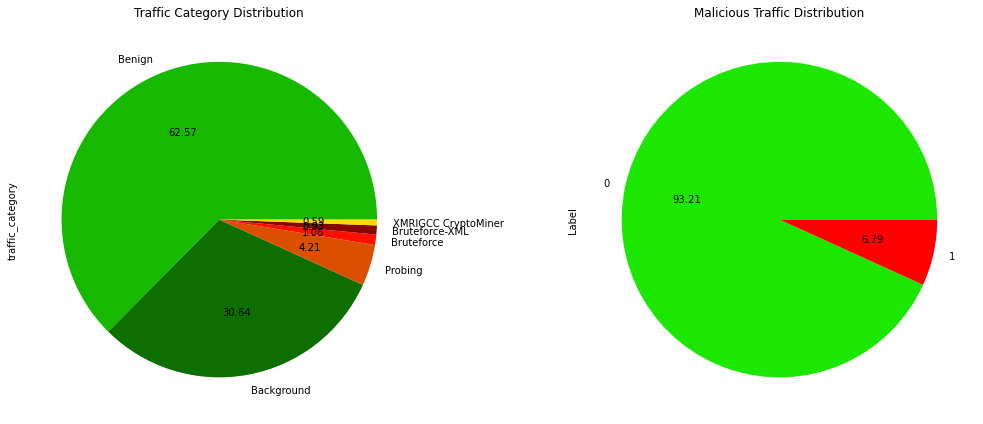

In [5]:
labels = df[['traffic_category', 'Label']].copy()
traffic_distribution = labels['traffic_category']
malicious_distribution= labels['Label']

traffic_colors = ["#16B900", "#0D6F00", "#DA4F00", "#FF0F00", "#870800", "#FFD800"]
malicious_colors = ["#1CE700", "#FF0000"]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns
traffic_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax1, title="Traffic Category Distribution",
                                             colors=traffic_colors)
malicious_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax2, title="Malicious Traffic Distribution",
                                               colors=malicious_colors)

plt.rcParams['text.color'] = 'white'
plt.tight_layout() 



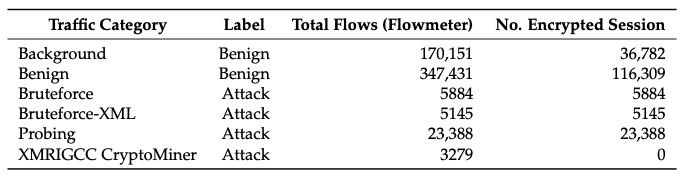

# Support Vector Machines Classification - Resampling

## Calculate the percentage distribution for the resampling

In [6]:
# Get the number of samples
samples_counter = labels['traffic_category'].count()
single_samples_counter = dict(labels['traffic_category'].value_counts())
non_mal_samples_counter = single_samples_counter['Benign'] + single_samples_counter['Background']
mal_samples_counter = single_samples_counter['Bruteforce'] + single_samples_counter['Bruteforce-XML'] + single_samples_counter['Probing'] + single_samples_counter['XMRIGCC CryptoMiner']
print('Number of samples:')
print('\t', end='')
print(samples_counter, non_mal_samples_counter, mal_samples_counter)

# Get the percentage distribution of the traffic in non-malicious & malicious
non_mal_percentage = round(non_mal_samples_counter/samples_counter * 100, 2)
mal_percentage = 100 - non_mal_percentage
print('Number of samples - percentage:')
print('\t', end='')
print(non_mal_percentage, mal_percentage)

# Get the percentage distribution of the non-malicious traffic
benign_percentage = round(single_samples_counter['Benign'] / non_mal_samples_counter * 100, 2)
background_percentage = 100 - benign_percentage
print('Number of samples - percentage for non-malicious traffic:')
print('\t', end='')
print(benign_percentage, background_percentage)

# Get the percentage distribution of the malicious traffic
bruteforce_percentage = round(single_samples_counter['Bruteforce'] / mal_samples_counter * 100, 2)
bruteforce_xml_percentage = round(single_samples_counter['Bruteforce-XML'] / mal_samples_counter * 100, 2)
probing_percentage = round(single_samples_counter['Probing'] / mal_samples_counter * 100, 2)
cryptominer_percentage = round(single_samples_counter['XMRIGCC CryptoMiner'] / mal_samples_counter * 100, 2)
print('Number of samples - percentage for malicious traffic:')
print('\t', end='')
print(bruteforce_percentage, bruteforce_xml_percentage, probing_percentage, cryptominer_percentage)

# calculate, on which size malicious and non-malicious must be sampled
percentage16_samples_counter = int(samples_counter * 0.16)
percentage24_samples_counter = int(samples_counter * 0.24)
percentage32_samples_counter = int(samples_counter * 0.32)
print('Number of samples for 16\%, 24\% and 32\%:')
print('\t', end='')
print(percentage16_samples_counter, percentage24_samples_counter, percentage32_samples_counter)


Number of samples:
	555278 517582 37696
Number of samples - percentage:
	93.21 6.790000000000006
Number of samples - percentage for non-malicious traffic:
	67.13 32.870000000000005
Number of samples - percentage for malicious traffic:
	15.61 13.65 62.04 8.7
Number of samples for 16\%, 24\% and 32\%:
	88844 133266 177688


## Scale and Normalize the dataset

In [7]:
# Drop the unnecessary values
df_labels = df[['traffic_category', 'Label']].copy()
df_values = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'uid', 'originh', 'originp', 'responh', 'responp', 'traffic_category', 'Label'])

# Scaling and Normalizing
scaler = preprocessing.StandardScaler().fit(df_values)
df_scaled = pd.DataFrame(scaler.transform(df_values))

# Normalizing
df_normalized = pd.DataFrame(preprocessing.normalize(df_scaled, norm='l2'))

# concat the labels with the scaled & normalized data
df_normalized['traffic_category'] = df_labels['traffic_category']
df_normalized['Label'] = df_labels['Label']
display(df_normalized)

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,traffic_category,Label
0,-0.013624,-0.001375,-0.002038,-0.005206,-0.004098,-0.067045,-0.071639,-0.070916,0.017689,-0.001908,...,-0.037785,-0.041995,-0.016773,-0.041536,-0.021669,0.188162,0.295889,-0.080253,Bruteforce-XML,1
1,0.011413,-0.001294,-0.001918,-0.004900,-0.003858,-0.063322,-0.067652,-0.066974,0.016650,-0.001546,...,0.120763,0.081753,0.013351,0.108173,-0.020396,0.177110,0.278511,-0.075540,Bruteforce-XML,1
2,0.005231,-0.001690,-0.002309,-0.004898,-0.004250,-0.063290,-0.067619,-0.066940,0.014933,-0.002129,...,0.086343,0.055054,0.006939,0.075750,-0.020388,0.177041,0.278402,-0.075510,Bruteforce-XML,1
3,0.001256,-0.001713,-0.002341,-0.004965,-0.004308,-0.064146,-0.068533,-0.067845,0.015137,-0.002158,...,0.064718,0.038114,0.002783,0.055301,-0.020667,0.179460,0.282206,-0.076542,Bruteforce-XML,1
4,-0.002823,-0.001731,-0.001965,-0.005019,-0.004354,-0.064822,-0.069251,-0.068558,0.041590,-0.002181,...,0.042312,0.020601,-0.001493,0.034133,-0.020889,0.181393,0.285246,-0.077367,Bruteforce-XML,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555273,-0.010345,-0.004211,-0.004558,-0.010720,-0.003827,-0.038986,-0.041651,-0.041234,-0.196148,-0.004033,...,-0.021885,-0.024323,-0.009715,-0.024058,-0.012551,-0.111257,-0.081532,-0.046483,XMRIGCC CryptoMiner,1
555274,-0.010345,-0.004211,-0.004558,-0.010720,-0.003827,-0.038986,-0.041651,-0.041234,-0.196148,-0.004033,...,-0.021885,-0.024323,-0.009715,-0.024058,-0.012551,-0.111257,-0.081532,-0.046483,XMRIGCC CryptoMiner,1
555275,-0.010345,-0.004211,-0.004558,-0.010720,-0.003827,-0.038986,-0.041651,-0.041234,-0.196148,-0.004033,...,-0.021885,-0.024323,-0.009715,-0.024058,-0.012551,-0.111257,-0.081532,-0.046483,XMRIGCC CryptoMiner,1
555276,-0.010345,-0.004211,-0.004558,-0.010720,-0.003827,-0.038986,-0.041651,-0.041234,-0.196148,-0.004033,...,-0.021885,-0.024323,-0.009715,-0.024058,-0.012551,-0.111257,-0.081532,-0.046483,XMRIGCC CryptoMiner,1


## Split the dataset into a training and test set

In [9]:
# Split the dataset
# --> df_train is the data, which will be resampled
# --> y_train are the labels for the test data, which will be adapted/changed to the label of the resized test set
# --> x_test and y_test are only used for the testing
df_train, x_test, y_train, y_test = train_test_split(df_normalized, labels['Label'], test_size=0.2)
print("Training set shape: " + str(df_train.shape))
print("Test set shape: " + str(x_test.shape))

# Drop any identifier (labels) from the test dataset
x_test = x_test.drop(columns=['traffic_category', 'Label'])

Training set shape: (444222, 81)
Test set shape: (111056, 81)


## Resample the traffic categories to 16%

16\% of samples for benign, background, bruteforce, bruteforce-xml, probing and the cryptominer:
	59640 29203 13868 12127 55118 7729


,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,traffic_category,Label
511645,-0.028492,-0.011628,-0.011918,-0.029598,-0.009897,-0.104979,-0.112075,-0.110992,0.068993,-0.011135,...,-0.060427,-0.067159,-0.026823,-0.066426,-0.034653,-0.307190,-0.225117,-0.128343,Benign,0
329266,-0.018130,-0.007381,-0.007565,-0.021487,-0.006706,0.320805,0.354297,0.344946,0.043793,-0.006708,...,-0.038355,-0.042628,-0.017026,-0.042163,-0.021996,0.191000,-0.142890,0.441697,Benign,0
525303,-0.016891,-0.003799,-0.002795,-0.012841,-0.003584,-0.064264,-0.068151,-0.067722,0.165931,-0.003671,...,-0.036793,-0.040892,-0.016332,-0.040446,-0.021100,0.183220,0.288118,-0.071237,Benign,0
355689,-0.006995,-0.002848,-0.003082,-0.007249,-0.002588,-0.026363,-0.028165,-0.027882,-0.132635,-0.002727,...,-0.014799,-0.016447,-0.006569,-0.016268,-0.008487,-0.075232,-0.055132,-0.031432,Benign,0
477348,0.055630,-0.000071,-0.001304,-0.001629,-0.002088,-0.043069,-0.046015,-0.045553,-0.026688,-0.000540,...,0.052476,0.204713,0.059196,0.150133,0.379037,0.120420,0.189364,-0.051361,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554837,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
554306,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
554887,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
554391,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1


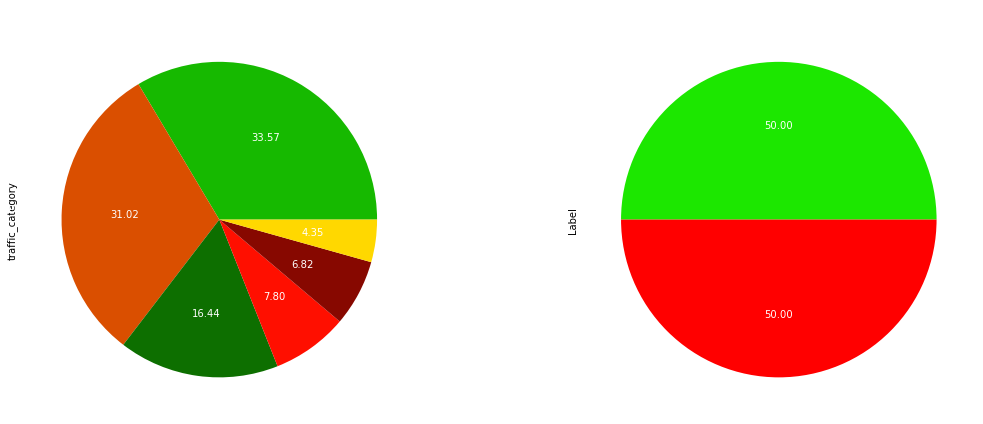

In [10]:
# Get the number of samples, every subset must be down-/upsampled
benign_sample_number = int(percentage16_samples_counter * (benign_percentage / 100))
background_sample_number = int(percentage16_samples_counter * (background_percentage / 100))
bruteforce_sample_number = int(percentage16_samples_counter * (bruteforce_percentage / 100))
bruteforce_xml_sample_number = int(percentage16_samples_counter * (bruteforce_xml_percentage / 100))
probing_sample_number = int(percentage16_samples_counter * (probing_percentage / 100)) 
cryptominer_sample_number = int(percentage16_samples_counter * (cryptominer_percentage / 100))
print('16\% of samples for benign, background, bruteforce, bruteforce-xml, probing and the cryptominer:')
print('\t', end='')
print(benign_sample_number, background_sample_number, bruteforce_sample_number, bruteforce_xml_sample_number, probing_sample_number, cryptominer_sample_number)


# Sample the dataset
bening_entries = df_train[df_train['traffic_category'] == "Benign"]
benign_sampling = resample(bening_entries, n_samples=benign_sample_number, random_state=42)

background_entries = df_train[df_train['traffic_category'] == "Background"]
background_sampling = resample(background_entries, n_samples=background_sample_number, random_state=42)

bruteforce_entries = df_train[df_train['traffic_category'] == "Bruteforce"]
bruteforce_sampling = resample(bruteforce_entries, n_samples=bruteforce_sample_number, random_state=42)

bruteforce_xml_entries = df_train[df_train['traffic_category'] == "Bruteforce-XML"]
bruteforce_xml_sampling = resample(bruteforce_xml_entries, n_samples=bruteforce_xml_sample_number, random_state=42)

probing_entries = df_train[df_train['traffic_category'] == "Probing"]
probing_sampling = resample(probing_entries, n_samples=probing_sample_number, random_state=42)

cryptominer_entries = df_train[df_train['traffic_category'] == "XMRIGCC CryptoMiner"]
cryptominer_sampling = resample(cryptominer_entries, n_samples=cryptominer_sample_number, random_state=42)

# Concat the dataset
df_16 = pd.concat([benign_sampling, background_sampling, bruteforce_sampling, bruteforce_xml_sampling, probing_sampling, cryptominer_sampling])
display(df_16)

# Show the new distribution
labels = df_16[['traffic_category', 'Label']].copy()
traffic_distribution = labels['traffic_category']
malicious_distribution= labels['Label']

traffic_colors = ["#16B900", "#DA4F00", "#0D6F00", "#FF0F00", "#870800", "#FFD800"]
malicious_colors = ["#1CE700", "#FF0000"]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns
traffic_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax1, title="Traffic Category Distribution", colors=traffic_colors)
malicious_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax2, title="Malicious Traffic Distribution", colors=malicious_colors)

plt.rcParams['text.color'] = 'white'
plt.tight_layout() 

## Prepare the 16% test data

In [11]:
# create the label-set for the 16% training data
y_train = df_16['Label'].copy()

# create a test set with the 16% values and without any identifier/lable
x_train = df_16.drop(columns=['traffic_category', 'Label'])

print("16% Training set shape:" + str(x_train.shape))
print("Test set shape:" + str(x_test.shape))

16% Training set shape:(177685, 79)
Test set shape:(111056, 79)


## Create a SVC Model with 16% resampled data

In [ ]:
if not os.path.exists('svc_models/traffic_analysis_16_balance_svc.model'):
    clf_16_balancing = SVC(gamma='auto')
    clf_16_balancing.fit(x_train, y_train)
    with open('svc_models/traffic_analysis_16_balance_svc.model', 'wb') as handle:
        pickle.dump(clf_16_balancing, handle)

## Test the 16% SVC Model

In [ ]:
# Load SVC Model from the previous step
with open('svc_models/traffic_analysis_16_balance_svc.model', 'rb') as handle:
    clf_16_balancing = pickle.load(handle)

# Test the no balancing SVC Model
pred_labels = clf_16_balancing.predict(x_test)
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89    103497
           1       0.26      0.90      0.40      7559

    accuracy                           0.82    111056
   macro avg       0.62      0.85      0.64    111056
weighted avg       0.94      0.82      0.86    111056



## Resample the traffic categories to 24%

24\% of samples for benign, background, bruteforce, bruteforce-xml, probing and the cryptominer:
	89461 43804 20802 18190 82678 11594


,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,traffic_category,Label
511645,-0.028492,-0.011628,-0.011918,-0.029598,-0.009897,-0.104979,-0.112075,-0.110992,0.068993,-0.011135,...,-0.060427,-0.067159,-0.026823,-0.066426,-0.034653,-0.307190,-0.225117,-0.128343,Benign,0
329266,-0.018130,-0.007381,-0.007565,-0.021487,-0.006706,0.320805,0.354297,0.344946,0.043793,-0.006708,...,-0.038355,-0.042628,-0.017026,-0.042163,-0.021996,0.191000,-0.142890,0.441697,Benign,0
525303,-0.016891,-0.003799,-0.002795,-0.012841,-0.003584,-0.064264,-0.068151,-0.067722,0.165931,-0.003671,...,-0.036793,-0.040892,-0.016332,-0.040446,-0.021100,0.183220,0.288118,-0.071237,Benign,0
355689,-0.006995,-0.002848,-0.003082,-0.007249,-0.002588,-0.026363,-0.028165,-0.027882,-0.132635,-0.002727,...,-0.014799,-0.016447,-0.006569,-0.016268,-0.008487,-0.075232,-0.055132,-0.031432,Benign,0
477348,0.055630,-0.000071,-0.001304,-0.001629,-0.002088,-0.043069,-0.046015,-0.045553,-0.026688,-0.000540,...,0.052476,0.204713,0.059196,0.150133,0.379037,0.120420,0.189364,-0.051361,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553823,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
553908,-0.018716,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
552260,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
553782,-0.018716,-0.008060,-0.009866,-0.016534,-0.008283,-0.084295,-0.090160,-0.089205,-0.424590,-0.008507,...,-0.047374,-0.052652,-0.021029,-0.052077,-0.027168,-0.240831,-0.176488,-0.100619,XMRIGCC CryptoMiner,1


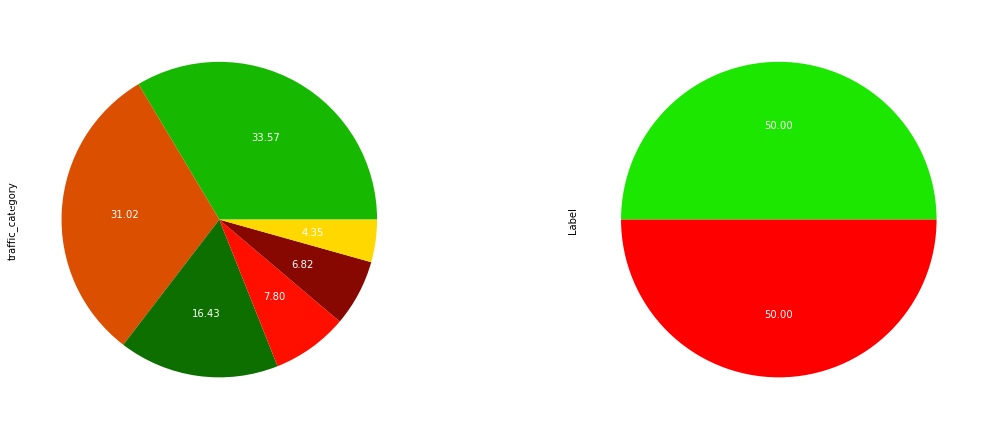

In [12]:
# Get the number of samples, every subset must be down-/upsampled
benign_24_sample_number = int(percentage24_samples_counter * (benign_percentage / 100))
background_24_sample_number = int(percentage24_samples_counter * (background_percentage / 100))
bruteforce_24_sample_number = int(percentage24_samples_counter * (bruteforce_percentage / 100))
bruteforce_xml_24_sample_number = int(percentage24_samples_counter * (bruteforce_xml_percentage / 100))
probing_24_sample_number = int(percentage24_samples_counter * (probing_percentage / 100)) 
cryptominer_24_sample_number = int(percentage24_samples_counter * (cryptominer_percentage / 100))
print('24\% of samples for benign, background, bruteforce, bruteforce-xml, probing and the cryptominer:')
print('\t', end='')
print(benign_24_sample_number, background_24_sample_number, bruteforce_24_sample_number, bruteforce_xml_24_sample_number, probing_24_sample_number, cryptominer_24_sample_number)


# Sample the dataset
bening_entries = df_train[df_train['traffic_category'] == "Benign"]
benign_sampling = resample(bening_entries, n_samples=benign_24_sample_number, random_state=42)

background_entries = df_train[df_train['traffic_category'] == "Background"]
background_sampling = resample(background_entries, n_samples=background_24_sample_number, random_state=42)

bruteforce_entries = df_train[df_train['traffic_category'] == "Bruteforce"]
bruteforce_sampling = resample(bruteforce_entries, n_samples=bruteforce_24_sample_number, random_state=42)

bruteforce_xml_entries = df_train[df_train['traffic_category'] == "Bruteforce-XML"]
bruteforce_xml_sampling = resample(bruteforce_xml_entries, n_samples=bruteforce_xml_24_sample_number, random_state=42)

probing_entries = df_train[df_train['traffic_category'] == "Probing"]
probing_sampling = resample(probing_entries, n_samples=probing_24_sample_number, random_state=42)

cryptominer_entries = df_train[df_train['traffic_category'] == "XMRIGCC CryptoMiner"]
cryptominer_sampling = resample(cryptominer_entries, n_samples=cryptominer_24_sample_number, random_state=42)

# Concat the dataset
df_24 = pd.concat([benign_sampling, background_sampling, bruteforce_sampling, bruteforce_xml_sampling, probing_sampling, cryptominer_sampling])
display(df_24)

# Show the new distribution
labels = df_24[['traffic_category', 'Label']].copy()
traffic_distribution = labels['traffic_category']
malicious_distribution= labels['Label']

traffic_colors = ["#16B900", "#DA4F00", "#0D6F00", "#FF0F00", "#870800", "#FFD800"]
malicious_colors = ["#1CE700", "#FF0000"]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns
traffic_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax1, title="Traffic Category Distribution", colors=traffic_colors)
malicious_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax2, title="Malicious Traffic Distribution", colors=malicious_colors)

plt.rcParams['text.color'] = 'white'
plt.tight_layout() 

## Prepare the test data

In [13]:
# create the label-set for the 24% training data
y_train = df_24['Label'].copy()

# create a test set with the 24% values and without any identifier/lable
x_train = df_24.drop(columns=['traffic_category', 'Label'])

print("24% Training set shape:" + str(x_train.shape))
print("General Test set shape:" + str(x_test.shape))

24% Training set shape:(266529, 79)
General Test set shape:(111056, 79)


## Create a SVC Model with 24% resampled data

In [ ]:
if not os.path.exists('svc_models/traffic_analysis_24_balance_svc.model'):
    clf_24_balancing = SVC(gamma='auto')
    clf_24_balancing.fit(x_train, y_train)
    with open('svc_models/traffic_analysis_24_balance_svc.model', 'wb') as handle:
        pickle.dump(clf_24_balancing, handle)

## Test the 24% SVC Model

In [ ]:
# Load SVC Model from the previous step
with open('svc_models/traffic_analysis_24_balance_svc.model', 'rb') as handle:
    clf_24_balancing = pickle.load(handle)

# Test the no balancing SVC Model
pred_labels = clf_24_balancing.predict(x_test)
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89    103497
           1       0.26      0.90      0.40      7559

    accuracy                           0.82    111056
   macro avg       0.63      0.86      0.65    111056
weighted avg       0.94      0.82      0.86    111056



## Resample the traffic categories to 32%

32\% of samples for benign, background, bruteforce, bruteforce-xml, probing and the cryptominer:
	119281 58406 27737 24254 110237 15458


,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,traffic_category,Label
511645,-0.028492,-0.011628,-0.011918,-0.029598,-0.009897,-0.104979,-0.112075,-0.110992,0.068993,-0.011135,...,-0.060427,-0.067159,-0.026823,-0.066426,-0.034653,-0.307190,-0.225117,-0.128343,Benign,0
329266,-0.018130,-0.007381,-0.007565,-0.021487,-0.006706,0.320805,0.354297,0.344946,0.043793,-0.006708,...,-0.038355,-0.042628,-0.017026,-0.042163,-0.021996,0.191000,-0.142890,0.441697,Benign,0
525303,-0.016891,-0.003799,-0.002795,-0.012841,-0.003584,-0.064264,-0.068151,-0.067722,0.165931,-0.003671,...,-0.036793,-0.040892,-0.016332,-0.040446,-0.021100,0.183220,0.288118,-0.071237,Benign,0
355689,-0.006995,-0.002848,-0.003082,-0.007249,-0.002588,-0.026363,-0.028165,-0.027882,-0.132635,-0.002727,...,-0.014799,-0.016447,-0.006569,-0.016268,-0.008487,-0.075232,-0.055132,-0.031432,Benign,0
477348,0.055630,-0.000071,-0.001304,-0.001629,-0.002088,-0.043069,-0.046015,-0.045553,-0.026688,-0.000540,...,0.052476,0.204713,0.059196,0.150133,0.379037,0.120420,0.189364,-0.051361,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553376,-0.018717,-0.008060,-0.009866,-0.016534,-0.008283,-0.084295,-0.090160,-0.089205,-0.424590,-0.008507,...,-0.047374,-0.052652,-0.021029,-0.052077,-0.027168,-0.240832,-0.176488,-0.100619,XMRIGCC CryptoMiner,1
553650,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
553548,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
552343,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1


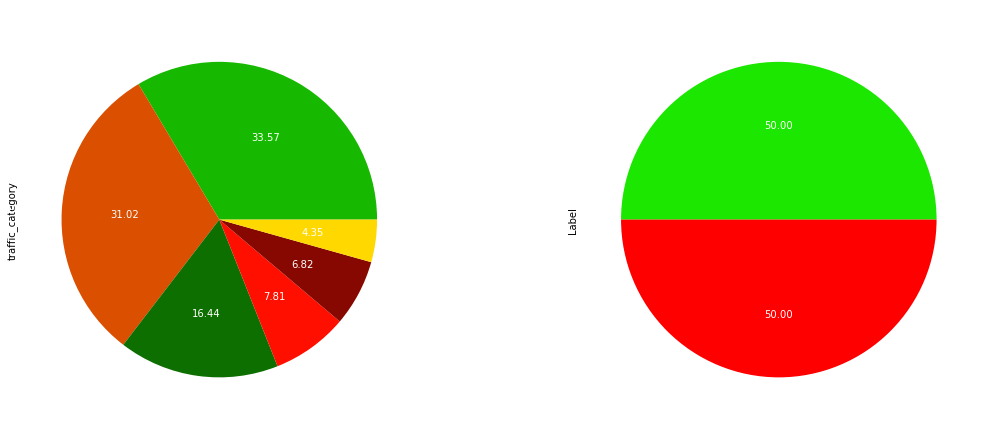

In [14]:
# Get the number of samples, every subset must be down-/upsampled
benign_32_sample_number = int(percentage32_samples_counter * (benign_percentage / 100))
background_32_sample_number = int(percentage32_samples_counter * (background_percentage / 100))
bruteforce_32_sample_number = int(percentage32_samples_counter * (bruteforce_percentage / 100))
bruteforce_xml_32_sample_number = int(percentage32_samples_counter * (bruteforce_xml_percentage / 100))
probing_32_sample_number = int(percentage32_samples_counter * (probing_percentage / 100)) 
cryptominer_32_sample_number = int(percentage32_samples_counter * (cryptominer_percentage / 100))
print('32\% of samples for benign, background, bruteforce, bruteforce-xml, probing and the cryptominer:')
print('\t', end='')
print(benign_32_sample_number, background_32_sample_number, bruteforce_32_sample_number, bruteforce_xml_32_sample_number, probing_32_sample_number, cryptominer_32_sample_number)


# Sample the dataset
from sklearn.utils import resample
bening_entries = df_train[df_train['traffic_category'] == "Benign"]
benign_sampling = resample(bening_entries, n_samples=benign_32_sample_number, random_state=42)

background_entries = df_train[df_train['traffic_category'] == "Background"]
background_sampling = resample(background_entries, n_samples=background_32_sample_number, random_state=42)

bruteforce_entries = df_train[df_train['traffic_category'] == "Bruteforce"]
bruteforce_sampling = resample(bruteforce_entries, n_samples=bruteforce_32_sample_number, random_state=42)

bruteforce_xml_entries = df_train[df_train['traffic_category'] == "Bruteforce-XML"]
bruteforce_xml_sampling = resample(bruteforce_xml_entries, n_samples=bruteforce_xml_32_sample_number, random_state=42)

probing_entries = df_train[df_train['traffic_category'] == "Probing"]
probing_sampling = resample(probing_entries, n_samples=probing_32_sample_number, random_state=42)

cryptominer_entries = df_train[df_train['traffic_category'] == "XMRIGCC CryptoMiner"]
cryptominer_sampling = resample(cryptominer_entries, n_samples=cryptominer_32_sample_number, random_state=42)

# Concat the dataset
df_32 = pd.concat([benign_sampling, background_sampling, bruteforce_sampling, bruteforce_xml_sampling, probing_sampling, cryptominer_sampling])
display(df_32)

# Show the new distribution
labels = df_32[['traffic_category', 'Label']].copy()
traffic_distribution = labels['traffic_category']
malicious_distribution= labels['Label']

traffic_colors = ["#16B900", "#DA4F00", "#0D6F00", "#FF0F00", "#870800", "#FFD800"]
malicious_colors = ["#1CE700", "#FF0000"]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns
traffic_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax1, title="Traffic Category Distribution", colors=traffic_colors)
malicious_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax2, title="Malicious Traffic Distribution", colors=malicious_colors)

plt.rcParams['text.color'] = 'white'
plt.tight_layout() 

## Prepare the test data

In [15]:
# create the label-set for the 32% training data
y_train = df_32['Label'].copy()
y_train_traffic_category = df_32['traffic_category'].copy()

# create a test set with the 32% values and without any identifier/lable
x_train = df_32.drop(columns=['traffic_category', 'Label'])

print("32% Training set shape:" + str(x_train.shape))
print("Test set shape:" + str(x_test.shape))

32% Training set shape:(355373, 79)
Test set shape:(111056, 79)


# Save 32% dataset for the PyTorch data

In [12]:
# create a dictiornary with the 32% dataset (test and train data)
coder = OneHotEncoder(sparse=False)

y_train_out = coder.fit_transform(y_train.to_numpy().reshape(len(y_train), 1))
y_test_out = coder.fit_transform(y_test.to_numpy().reshape(len(y_test), 1))
pytorch_data = [x_train, x_test, y_train_out, y_test_out]

y_train_out_traffic_category = coder.fit_transform(y_train_traffic_category.to_numpy().reshape(len(y_train_traffic_category), 1))
y_test_out_traffic_category = coder.fit_transform(y_test_category.to_numpy().reshape(len(y_test_category), 1))
pytorch_data_traffic_category = [x_train, x_test, y_train_out_traffic_category, y_test_out_traffic_category]

# save/export the dictionary
with open("pytorch/resampled_32.pickle", 'wb') as handle:
        pickle.dump(pytorch_data, handle)

# save/export the dictionary
with open("pytorch/resampled_32_traffic_category.pickle", 'wb') as handle:
        pickle.dump(pytorch_data_traffic_category, handle)

## Create a SVC Model with 32% resampled data

In [ ]:
if not os.path.exists('svc_models/traffic_analysis_32_balance_svc.model'):
    clf_32_balancing = SVC(gamma='auto')
    clf_32_balancing.fit(x_train, y_train)
    with open('svc_models/traffic_analysis_32_balance_svc.model', 'wb') as handle:
        pickle.dump(clf_32_balancing, handle)

## Test the 32% SVC Model

In [ ]:
with open('svc_models/traffic_analysis_32_balance_svc.model', 'rb') as handle:
    clf_32_balancing = pickle.load(handle)

# Test the no balancing SVC Model
pred_labels = clf_32_balancing.predict(x_test)
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89    103497
           1       0.27      0.99      0.43      7559

    accuracy                           0.82    111056
   macro avg       0.64      0.90      0.66    111056
weighted avg       0.95      0.82      0.86    111056

